Tutorial pubished by UNidata, makers of Siphon, here: https://www.youtube.com/watch?v=uZIC8nAxSzY

In [59]:
#%pip install netCDF4 -q
#%pip install siphon -q
#%pip install metpy -q
#%pip install pytz

In [60]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from metpy.units import units

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

from xarray.backends import NetCDF4DataStore
import xarray as xr

from datetime import datetime, timedelta, timezone
from netCDF4 import num2date
from siphon.catalog import TDSCatalog

import pytz

In [61]:
# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coords:
        if coord_name.startswith(time_basename):
            return var.coords[coord_name]
    raise ValueError('No time variable found for ' + var.name)

In [62]:
geojson_path = '/workspace/notebooks/sandbox/data/input-data/dissolved-boundaries.geojson'
gdf = gpd.read_file(geojson_path)
bbox = gdf.total_bounds  # Returns [minx, miny, maxx, maxy]

wa_bbox = [110, -37.0, 131.0, -11]
print("Bounding Box:", bbox)
print("Bounding Box for WA:", wa_bbox)

Bounding Box: [116.2601213  -29.30738472 116.38758624 -29.22023779]
Bounding Box for WA: [110, -37.0, 131.0, -11]


Construct an instance of TDSCatalog pointing to dataset of interest. In this case, TDS "Best" virtual dataset for the GFS global 0.25 degree collection of GRIB files. This catalog contains a single dataset.

In [63]:
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best')

print(list(best_gfs.datasets))

['Best GFS Quarter Degree Forecast Time Series']


We pull out this dataset and call subset() to set up requesting a subset of the data. We can then use the ncss object to create a new query object, which facilitates asking for data from the server.

Then construct a query asking for data corresponding to a bounding box. Note that longitude values are the longitude distance from the prime meridian. 

Request the data for the current time. This request will return all surface temperatures for points in our bounding box for a single time. Note the string representation of the query is a properly encoded query string. Use timedelta to then get the 24 hour forecast timebock.

In [64]:
# the actual dataset from best_gfs, then netCDF subset service. This isn't downloading data, just metadata

#set up start and end time using current timestamp, to get rolling 24-hour forecast data
start_time = datetime.now(timezone.utc)
end_time = now + timedelta(days=1)

ncss = best_gfs.datasets[0].subset()

# define the query that will be used to fetch the data
query = ncss.query()
query.time_range(start_time, end_time)
query.accept('netcdf4')
query.variables('Temperature_surface')
query.lonlat_box(north=wa_bbox[3], south=wa_bbox[1], east=wa_bbox[2], west=wa_bbox[0])

#ncss.variables

var=Temperature_surface&time_start=2024-03-20T02%3A31%3A58.430590%2B00%3A00&time_end=2024-03-21T02%3A03%3A27.468166%2B00%3A00&west=110&east=131.0&south=-37.0&north=-11&accept=netcdf4

Request data from the server using the query. The NCSS class handles parsing NetCDF data.

In [74]:
data = ncss.get_data(query)
print(list(data.variables))

['reftime', 'latitude', 'time', 'longitude', 'Temperature_surface', 'LatLon_721X1440-0p13S-180p00E-2']


In [75]:
data = xr.open_dataset(NetCDF4DataStore(data))
data

<xarray.Dataset> Size: 322kB
Dimensions:                          (time: 9, latitude: 105, longitude: 85)
Coordinates:
    reftime                          (time) datetime64[ns] 72B ...
  * latitude                         (latitude) float32 420B -11.0 ... -37.0
  * time                             (time) datetime64[ns] 72B 2024-03-20T03:...
  * longitude                        (longitude) float32 340B 110.0 ... 131.0
Data variables:
    Temperature_surface              (time, latitude, longitude) float32 321kB ...
    LatLon_721X1440-0p13S-180p00E-2  int32 4B ...
Attributes: (12/13)
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    ...                                                                                ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...

In [67]:
temp_3d = data['Temperature_surface']

temp_3d

<xarray.DataArray 'Temperature_surface' (time: 9, latitude: 105, longitude: 85)> Size: 321kB
[80325 values with dtype=float32]
Coordinates:
    reftime    (time) datetime64[ns] 72B ...
  * latitude   (latitude) float32 420B -11.0 -11.25 -11.5 ... -36.5 -36.75 -37.0
  * time       (time) datetime64[ns] 72B 2024-03-20T03:00:00 ... 2024-03-21T0...
  * longitude  (longitude) float32 340B 110.0 110.2 110.5 ... 130.5 130.8 131.0
Attributes:
    long_name:                       Temperature @ Ground or water surface
    units:                           K
    Grib_Variable_Id:                VAR_7-0--1-0_L1
    Grib2_Parameter:                 [0 0 0]
    Grib2_Parameter_Discipline:      Meteorological products
    Grib2_Parameter_Category:        Temperature
    Grib2_Parameter_Name:            Temperature
    Grib2_Level_Type:                1
    Grib2_Level_Desc:                Ground or water surface
    Grib2_Generating_Process_Type:   Forecast
    Grib2_Statistical_Process_Type:  UnknownStatType--1
    grid_mapping:                    LatLon_721X1440-0p13S-180p00E-2

Pull out latitude, longitude, and time (in hours since the forecast run).

Process data to be suitable for plotting. Combine lat/longs (meshgrid) and remove one-dimensional entities from arrays (squeeze). 

Use netCDF4's num2date to change the time since the model run to an actual date.

In [68]:
# extract latitude and longitude to create gridmesh
lat_1d = data['latitude']
lon_1d = data['longitude']

# Combine latitude and longitudes 
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)


In [69]:
# Reduce the dimensions of the data and get as an array with units
temp_2d = temp_3d.metpy.unit_array.squeeze()


Plot using matplotlib and cartopy.

In [70]:
time_values = data.variables['time']
# Calculate the number of 4-hour intervals
num_intervals = len(time_values) // 4

num_intervals

2

AttributeError: 'IndexVariable' object has no attribute 'units'

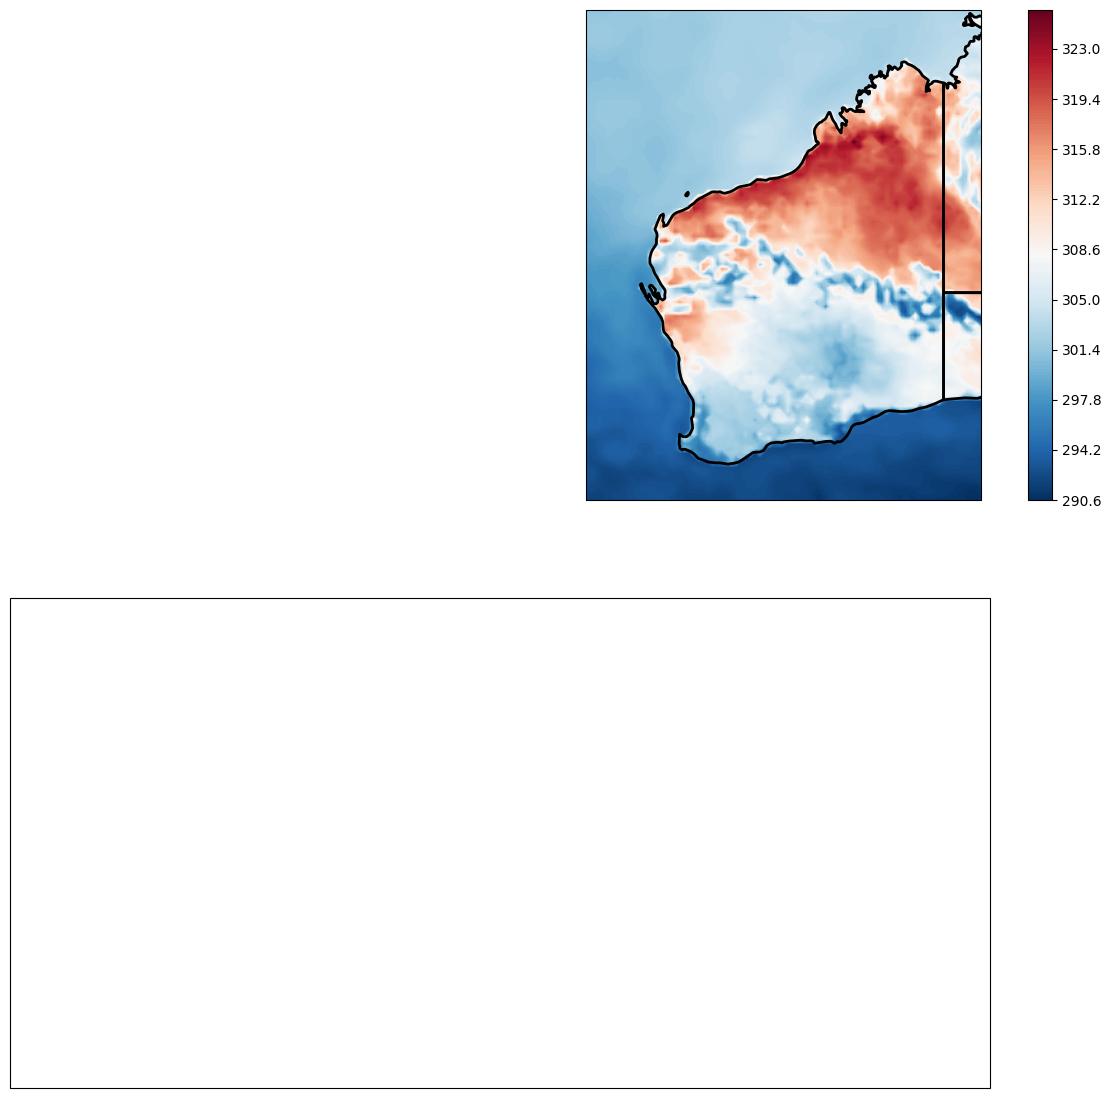

In [71]:
# Create a figure with a subplot for each 4-hour interval
fig, axs = plt.subplots(num_intervals, figsize=(15, 7 * num_intervals), subplot_kw={'projection': ccrs.PlateCarree()})

for i in range(num_intervals):
    # Slice the temperature data at the current 4-hour interval
    temp_2d = temp_3d[i * 4, :, :]
    
    # Set extent for the current subplot
    axs[i].set_extent([wa_bbox[0], wa_bbox[2], wa_bbox[1], wa_bbox[3]], crs=ccrs.PlateCarree())

    # Add features to the current subplot
    axs[i].add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
    axs[i].add_feature(cfeature.STATES, linewidth=2)

    # Contour temperature at each lat/long
    contours = axs[i].contourf(lon_2d, lat_2d, temp_2d, 200, transform=ccrs.PlateCarree(),
                               cmap='RdBu_r')

    # Plot a colorbar to show temperature and reduce the size of it
    fig.colorbar(contours, ax=axs[i], fraction=0.046, pad=0.04)

    # Make a title with the time value
    time_string = num2date(time_values[i * 4], time_values.units.item())
    axs[i].set_title(f'Temperature forecast (\u00b0C) for {time_string}', fontsize=14)

## original code don't touch yet

In [ ]:
time_1d = find_time_var(temp_3d)
time_1d

<xarray.DataArray 'time' (time: 9)> Size: 72B
array(['2024-03-20T03:00:00.000000000', '2024-03-20T06:00:00.000000000',
       '2024-03-20T09:00:00.000000000', '2024-03-20T12:00:00.000000000',
       '2024-03-20T15:00:00.000000000', '2024-03-20T18:00:00.000000000',
       '2024-03-20T21:00:00.000000000', '2024-03-21T00:00:00.000000000',
       '2024-03-21T03:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    reftime  (time) datetime64[ns] 72B ...
  * time     (time) datetime64[ns] 72B 2024-03-20T03:00:00 ... 2024-03-21T03:...
Attributes:
    standard_name:  time
    long_name:      GRIB forecast or observation time

In [ ]:
formatted_time = pd.to_datetime(time_1d.values).tz_localize('UTC').to_series().dt.tz_convert('Australia/Perth')
formatted_time = formatted_time.dt.strftime('%Y-%m-%d %H:%M')
time_string = formatted_time.values[0]

AttributeError: 'DataArray' object has no attribute 'to'

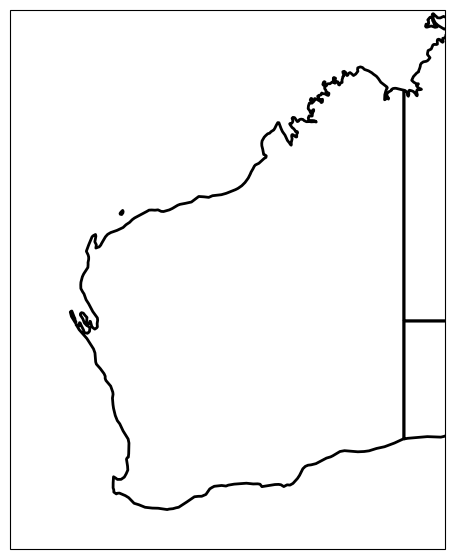

In [ ]:
# boilerplate to set up a basic map
crs=ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15, 7), subplot_kw={'projection': crs})

# Set extent for both subplots
ax.set_extent([wa_bbox[0], wa_bbox[2], wa_bbox[1], wa_bbox[3]], crs=ccrs.PlateCarree())

# Add features to both subplots
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=2)

# Contour temperature at each lat/long
contours = ax.contourf(lon_2d, lat_2d, temp_2d.to('degC'), 200, transform=ccrs.PlateCarree(),
                      cmap='RdBu_r')
#Plot a colorbar to show temperature and reduce the size of it
fig.colorbar(contours)

# Make a title with the time value
ax.set_title(f'Temperature forecast (\u00b0C) for {time_string}', fontsize=14)
